In [6]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.datasets import load_boston
bdata = load_boston()

In [3]:
print (bdata.keys())
print (bdata.feature_names)
print (bdata.data.shape)
print (bdata.target.shape)
# uncomment the following if you want to see a lengthy description of the dataset
# print (bdata.target)

dict_keys(['data', 'DESCR', 'feature_names', 'target'])
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
(506, 13)
(506,)


In [4]:
# Creating an array with all the independent and dependent variable.
bdata_full = np.insert(bdata.data, bdata.data.shape[1], bdata.target, axis = 1)

---

## Part 1: Descriptive analysis

### 1.1: Histogram of housing prices

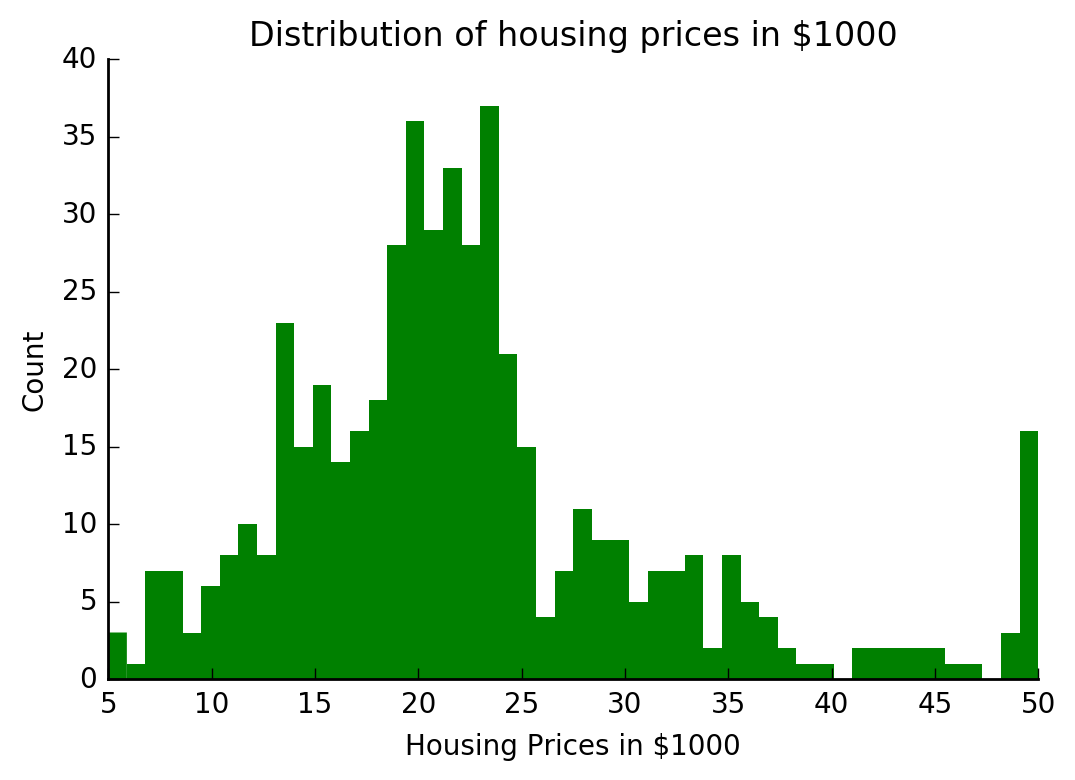

In [5]:
# Plotting histogram
plt.hist(bdata_full[:,13], color = 'green',bins=50,edgecolor = "none")
ax = plt.axes()
ax.spines['right'].set_color('none') # Remove right axis
ax.spines['top'].set_color('none') # Remove top axis
ax.get_xaxis().tick_bottom() # Remove top ticks
ax.get_yaxis().tick_left() # Remove right ticks
plt.xlabel('Housing Prices in $1000')
plt.ylabel('Count')
plt.title('Distribution of housing prices in $1000')

### 1.2: Scatter plot of housing prices and crime

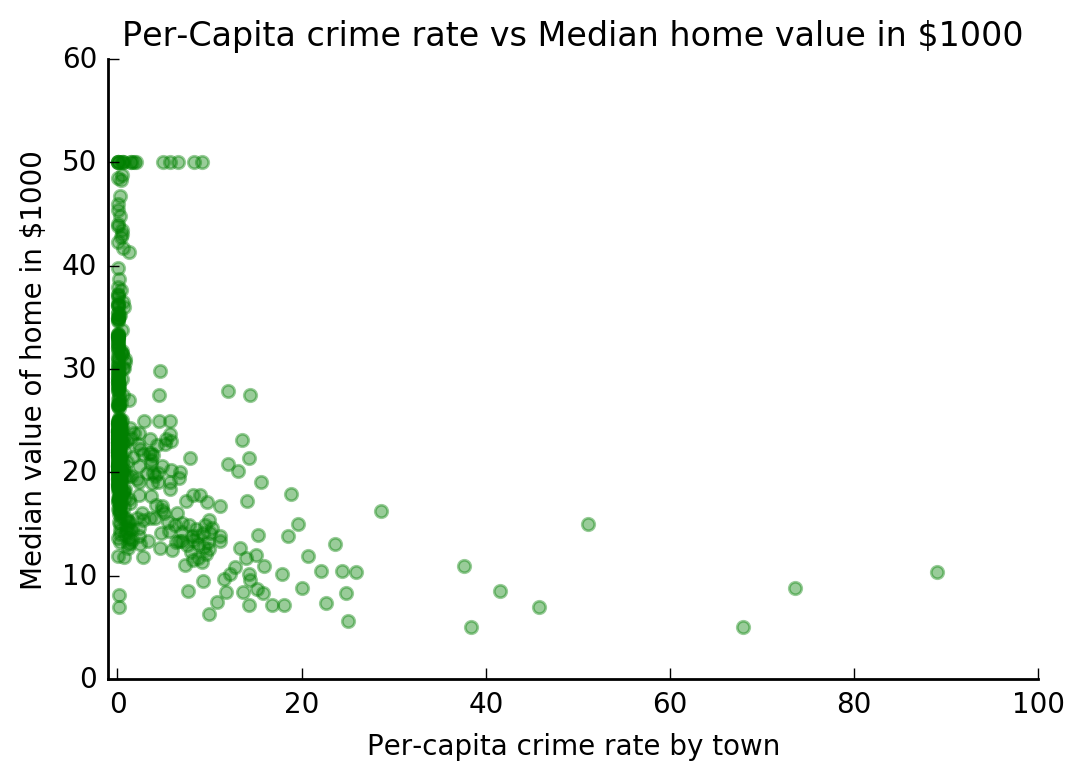

In [6]:
plt.scatter(bdata_full[:,0],bdata_full[:,13],alpha = 0.4, color = 'green')
plt.xlim(-1, 100)
plt.xlabel('Per-capita crime rate by town')
plt.ylabel('Median value of home in $1000')
plt.title('Per-Capita crime rate vs Median home value in $1000')
ax = plt.axes()
ax.spines['right'].set_color('none') # Remove right axis
ax.spines['top'].set_color('none') # Remove top axis
ax.get_xaxis().tick_bottom() # Remove top ticks
ax.get_yaxis().tick_left() # Remove right ticks

### 1.3 Create your own (creative and effective) visualization 

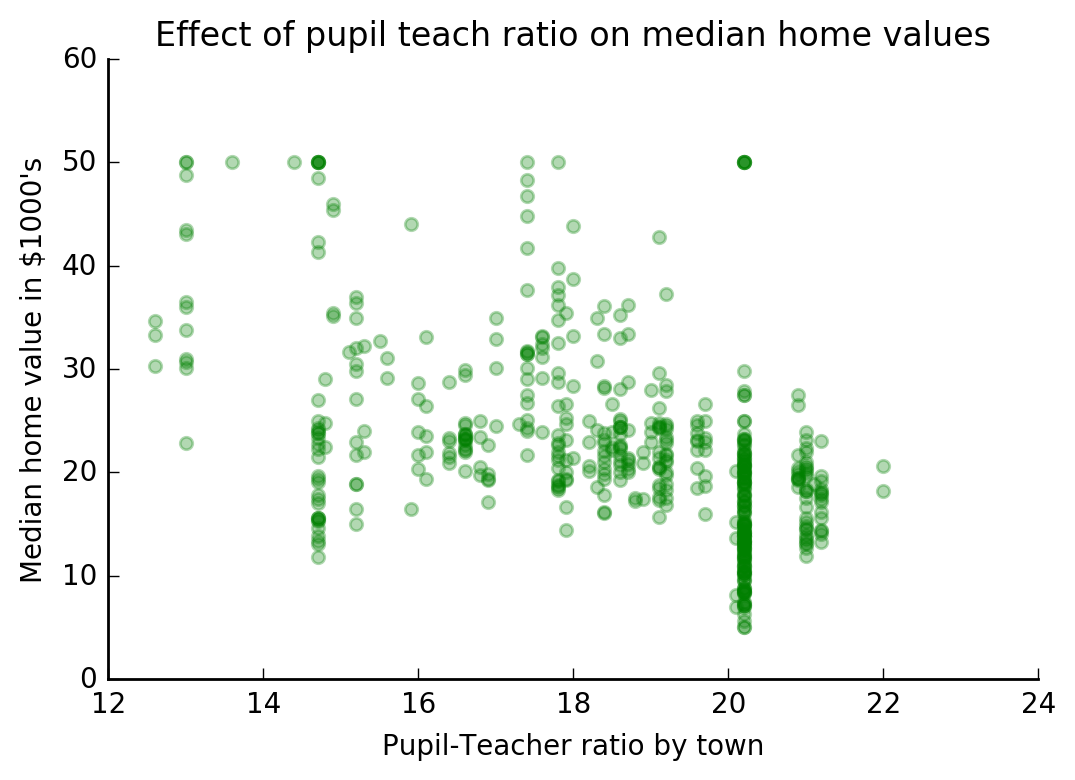

In [7]:
plt.scatter(bdata_full[:,10],bdata_full[:,13],color = 'green', alpha = 0.3)
ax = plt.axes()
ax.spines['right'].set_color('none') # Remove right axis
ax.spines['top'].set_color('none') # Remove top axis
ax.get_xaxis().tick_bottom() # Remove top ticks
ax.get_yaxis().tick_left() # Remove right ticks
plt.xlabel('Pupil-Teacher ratio by town')
plt.ylabel('Median home value in $1000\'s')
plt.title('Effect of pupil teach ratio on median home values')

I wanted to understand whether availability of quality education affects the median home values. From the above plot, we see that as the Pupil-Teacher ratio increases, there is a declining trend in the median home prices. This means, areas where the quality of education in terms of the potential to cater to pupil's individually is better (Marked by low Pupil-teacher ration), the median home prices are on the higher side. Similarly, as the ability to cater to individuals reduces (Increasing Pupil-Teacher ration), the median home prices starts decreasing.

---

## Part 2: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for an instance in the data.

### 2.1 Writing a function to compute the Root Mean Squared Error for a list of numbers


In [8]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print compute_rmse((2,2,3),(0,2,6)
2.08
"""

def compute_rmse(predictions, yvalues):
    squared = (np.asarray(predictions) - np.asarray(yvalues)) **2
    root_ms = np.sqrt(squared.sum()/len(predictions))
    return root_ms

In [9]:
print (compute_rmse(np.asarray((2,2,3)),np.asarray((0,2,6))))

2.08166599947


### 2.2 Dividing data into training and testing datasets

In [10]:
# Leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
def tt_split(df, percent):
    # Set random seed for reproducibility
    np.random.seed(seed=13579)
    # Shuffle data before splitting
    np.random.shuffle(df)
    # Assign data to train set as per defined split
    bdata_train = df[0:np.int(percent*len(df)),:]
    # Assign data to test set
    bdata_test = df[np.int(percent*len(df)):len(df),:]
    # Return train and test data
    return bdata_train,bdata_test

In [11]:
bdata_train, bdata_test = tt_split(bdata_full, 0.66)

In [12]:
print("Percentage of observations in training set:",np.round(bdata_train.shape[0]/bdata_full.shape[0],2)*100)

Percentage of observations in training set: 66.0


In [13]:
print("Percentage of observations in test set:",np.round(bdata_test.shape[0]/bdata_full.shape[0],2)*100)

Percentage of observations in test set: 34.0


### 2.3 Use a trivial baseline model for prediction, and compute RMSE
I will create a model that predicts, for every observation x_i, that the median home value is the average (mean) of the median values for all instances in the training set.

In [14]:
# print("Root mean Squared error on the training set is:",compute_rmse([bdata_train[:,13].mean()],bdata_train[:,13]))
print("Root mean Squared error on the training set is:",compute_rmse(np.repeat(bdata_train[:,13].mean(),bdata_train.shape[0]),bdata_train[:,13]))
# print("Root mean Squared error on the test set is:",compute_rmse([bdata_train[:,13].mean()],bdata_test[:,13]))
print("Root mean Squared error on the test set is:",compute_rmse(np.repeat(bdata_train[:,13].mean(),bdata_test.shape[0]),bdata_test[:,13]))

Root mean Squared error on the training set is: 8.58496788378
Root mean Squared error on the test set is: 10.2816716248


We get a lower RMSE value of 8.58 for the training set , compared to the RMSE value of 10.28 on the test set. This is expected, since our baseline model uses the mean value of data points on the training set, this would be closer to the actual values on the training set. Hence, a lower value of RMSE on the training set.

### 3.1 Nearest Neighbors: Distance function
Let's try and build a machine learning algorithm to beat the "Average
Value" baseline that we computed above.  Soon we will implement the
Nearest Neighbor algorithm, but first we need to create a distance
metric to measure the distance (and similarity) between two instances.

In [15]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print distance((3,4),(5,9),1)
7

"""
def distance(x1, x2, L):
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    dist = np.power(np.abs(x1-x2),L)
    return np.power(dist.sum(axis=0),float(1)/L)

In [16]:
print ("Eucledean distance(L2) between (3,4),(6,8):", distance((3,4),(6,8),2))
print ("Eucledean distance(L2) between (6,8),(3,4):", distance((3,4),(6,8),2))
print ("\nManhatten distance(L1) between (3,4),(6,8):", distance((3,4),(6,8),1))
print ("Manhatten distance(L1) between (6,8),(3,4):", distance((3,4),(6,8),1))

Eucledean distance(L2) between (3,4),(6,8): 5.0
Eucledean distance(L2) between (6,8),(3,4): 5.0

Manhatten distance(L1) between (3,4),(6,8): 7.0
Manhatten distance(L1) between (6,8),(3,4): 7.0


### 3.2 Basic Nearest Neighbor algorithm

Now things get fun.  We will implement a basic nearest neighbor algorithm from scratch. The simple model will use two input features (CRIM and RM) and a single output (MEDV).  In other words, we are modelling the relationship between median home value and crime rates and house size.

In [17]:
#Alternate
"""
# write your function specification here!
"""
# Importing time for calculating function runtime
import time
import operator

def knn_predict(test_data, train_data, L):
    # Recording start time of function run
    start_time = time.time()
    # List to store predicted values
    a = []
    for i in test_data:
        # List to store calculated distances
        eu_Distance = []
        for j in train_data:
            # Calculate the distance
            eu_dist = distance(j[:-1],i[:-1],L)
            # Append to the list created earlier
            eu_Distance.append((j[j.shape[0]-1], eu_dist))
            #Sort the list by distance , so that we can pick the lowest distance
        eu_Distance.sort(key = operator.itemgetter(1),reverse = False)           
        # Append the training set value , corresponding to the lowest distance
        a.append(eu_Distance[0])
    # Convert to array
    a = np.array(a)
    # Calculate runtime
    total_t = float(round(time.time() - start_time,2))
    # Return the predicted value, root mean squared error and the time take for run
    return a[:,0],compute_rmse(test_data[:,(test_data.shape[1]-1)],a[:,0]),total_t

In [18]:
predictions , rmse , time_taken = knn_predict(bdata_test[:,(0,5,13)], bdata_train[:,(0,5,13)],2)

In [19]:
print("Root mean squared error is:",rmse)
print("Total time for computation is:",time_taken,"Seconds")

Root mean squared error is: 7.45009989459
Total time for computation is: 0.7 Seconds


We see our RMSE value of 7.45 is lower that the value we got using the baseline model. Hence, the nearest neighbour algorithm is an improvement over the baseline model.

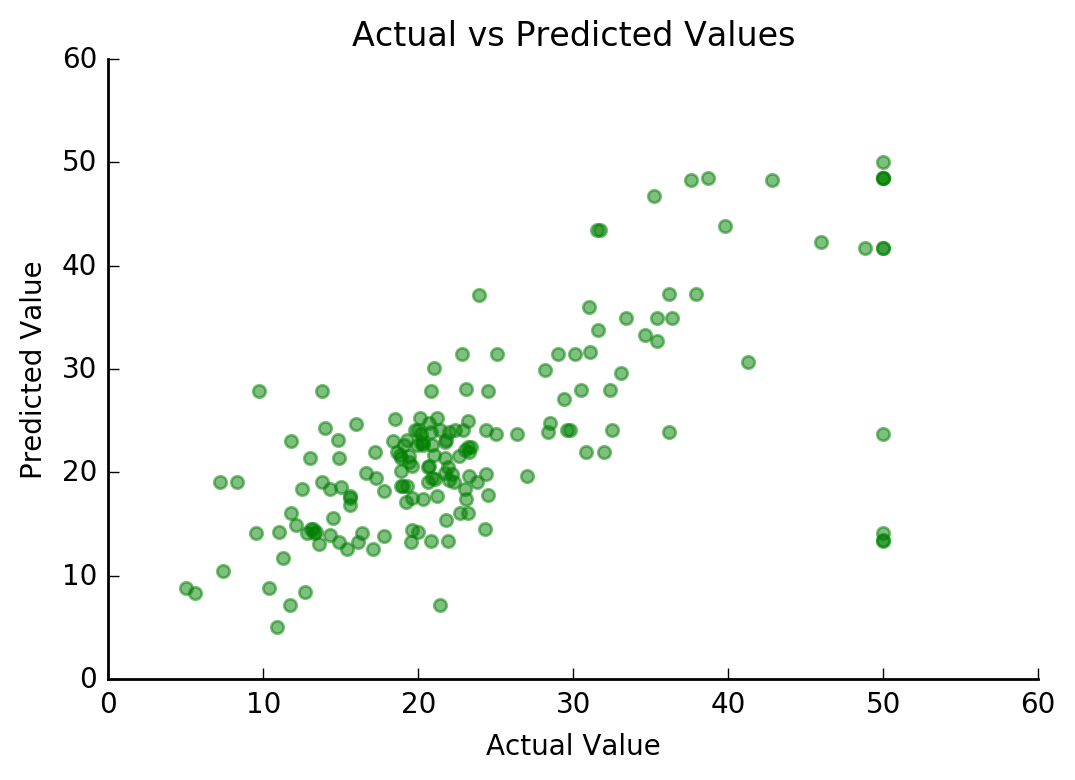

In [20]:
plt.scatter(bdata_test[:,13],predictions,color = 'green',alpha = 0.5)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Actual vs Predicted Values')
ax = plt.axes()
ax.spines['right'].set_color('none') # Remove right axis
ax.spines['top'].set_color('none') # Remove top axis
ax.get_xaxis().tick_bottom() # Remove top ticks
ax.get_yaxis().tick_left() # Remove right ticks

### 3.3 Results and Normalization
We will write a simple generic normalization function that takes as input an array of values for a given feature, and returns the normalized array. 

Then we re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations.

In [21]:
def normalize(data):
    for j in range(0,(data.shape[1]-1)):
        # Finding mean of all independent variables. Excluding our dependant variable column.
        mean = data[:,j].mean()
        # Finding Standard Deviation of all independent variables. Excluding our dependant variable column.
        std = data[:,j].std()
        # Normalizing the data
        data[:,j] = (data[:,j]-mean)/std
    return data

In [22]:
predictions , rmse , time_taken = knn_predict(normalize(bdata_test[:,(0,5,13)]), normalize(bdata_train[:,(0,5,13)]),2)

In [23]:
print("Root Mean Squared error after normalizations is:",rmse)

Root Mean Squared error after normalizations is: 7.73437264626


After normalization, we get a RMSE value of 7.73, which is higher than the RMSE of 7.45 without normalization. While our RMSE has increased, this value is more accurate as it ensures that features with higher scales do not dominate the distance calculations.

### 3.4 Optimization


A lot of the decisions we've made so far have been arbitrary. We will try to increase the performance of our nearest neighbor algorithm by adding features that we think might be relevant, and by using different values of L in the distance function.

In [24]:
'''
6 - AGE      proportion of owner-occupied units built prior to 1940
11 - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
9 - TAX      full-value property-tax rate per $10,000
3 - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5 - NOX      nitric oxides concentration (parts per 10 million)
'''
predictions , rmse , time_taken = knn_predict(normalize(bdata_test[:,(0,5,13)]), normalize(bdata_train[:,(0,5,13)]),3)
print("RMSE value using L=3:",rmse)
print("Runtime:",time_taken,"Seconds")

predictions , rmse , time_taken = knn_predict(normalize(bdata_test[:,(10,12,13)]), normalize(bdata_train[:,(10,12,13)]),4)
print("\nRMSE value using L=4:",rmse)
print("Runtime:",time_taken,"Seconds")

predictions , rmse , time_taken = knn_predict(normalize(bdata_test[:,(11,9,13)]), normalize(bdata_train[:,(11,9,13)]),2)
print("\nRMSE value by using features a) Proportion of blacks by town and b) Tax Rate:",rmse)
print("Runtime:",time_taken,"Seconds")

predictions , rmse , time_taken = knn_predict(normalize(bdata_test[:,(0,5,9,12,13)]), normalize(bdata_train[:,(0,5,9,12,13)]),2)
print("\nRMSE value using 4 features and L = 2:",rmse)
print("Runtime:",time_taken,"Seconds")

predictions , rmse , time_taken = knn_predict(normalize(bdata_test[:,(0,5,9,12,13)]), normalize(bdata_train[:,(0,5,9,12,13)]),4)
print("\nRMSE value using 4 features and L = 4:",rmse)
print("Runtime:",time_taken,"Seconds")

RMSE value using L=3: 7.75256437157
Runtime: 0.7 Seconds

RMSE value using L=4: 6.55767211622
Runtime: 0.67 Seconds

RMSE value by using features a) Proportion of blacks by town and b) Tax Rate: 11.2786436892
Runtime: 0.68 Seconds

RMSE value using 4 features and L = 2: 5.84369627267
Runtime: 0.68 Seconds

RMSE value using 4 features and L = 4: 5.98388490972
Runtime: 0.68 Seconds


Different combination of features and L value produces different RMSE values. While in certain cases, such as using 4 features (0,5,9,12) and L value of 2, we were able to substantially decrease our RMSE value. In certain cases such as L =3 or using a different combination of features, our RMSE value shot up substantially. Hence, it is important to get a correct combination of features and L values to build a good model.
I got the lowest RMSE for a model with Features ZN,RM,TAX,LSTAT with a L value of 2.

While the runtime did fluctuate with the algorithms, it was very minor.

### 3.5 Cross-Validation

The more we tinkered with our features and distance function, the higher the risk that you overfit your training data.  To prevent this sort of overfitting, we need to use cross-validation.

We will use Euclidean distance with CRIM and RM (0 and 5) as features.

In [25]:
def kfold(data,L,s,k):
    # Shuffling the data before running cross validation, to remove any underlying time-series patterns in data if present.
    np.random.seed(seed=13579)
    np.random.shuffle(data)
    # Variable to initialize rmse value
    rmse = 0
    # Variable to calculate run time of algorithm
    t_total = 0
    for i in range(10):
        # Assign 10 percent of the data to test set
        test = data[(range(int(float(i)/10*data.shape[0]),int((float(i+1)/10)*data.shape[0]))),:]
        # Assign the rest 90% of the data to train set
        train = np.delete(data,(range(int(float(i)/10*data.shape[0]),int((float(i+1)/10)*data.shape[0]))), axis=0)
        if s=='knn':
            p,r,t = knn(normalize(test[:,:]), normalize(train[:,:]),2,k)
        if s=='nn':
            p,r,t = knn_predict(normalize(test[:,:]), normalize(train[:,:]),2)
        rmse += r
        t_total += t
    return (rmse/10),t_total

In [26]:
rmse,t_final = kfold(bdata_full[:,(0,5,13)],2,'nn',3)

In [27]:
print('Root mean squared error after 10 fold cross-validation:',rmse)
print('Time taken to run cross-validation:',t_final,"seconds")

Root mean squared error after 10 fold cross-validation: 6.82560990421
Time taken to run cross-validation: 2.59 seconds


We see that after running k-fold cross-validation with k = 10, our root mean squared error has reduced to 6.82.
Our earlier value was 7.73 , when we calculated the training-test split RMSE using the same features.

### 3.6 K-Nearest Neighbors Algorithm

In [31]:
import time
def knn(test_data, train_data, L,k):
    # Recording start time of function run
    start_time = time.time()
    # List to store predicted values
    a = []
    for i in test_data:
        # List to store calculated distances
        eu_Distance = []
        for j in train_data:
            # Calculate the distance
            eu_dist = distance(j[:-1],i[:-1],L)
            # Append to the list created earlier
            eu_Distance.append((j[j.shape[0]-1], eu_dist))
            # Sort the list by distance , so that we can pick the lowest distance
        eu_Distance.sort(key = operator.itemgetter(1),reverse = False)
            # Append the training set value , corresponding to the lowest distance
        a.append(np.mean(eu_Distance[0:k],axis = 0))
    # Convert to array
    a = np.array(a)
    # Calculate runtime
    total_t = float(round(time.time() - start_time,2))
    # Return the predicted value, root mean squared error and the time take for run
    return a[:,0],compute_rmse(test_data[:,(test_data.shape[1]-1)],a[:,0]),total_t

In [32]:
r,t = kfold(bdata_full[:,(0,5,13)],2,'knn',3)

In [33]:
print("Root mean squared error using 10-fold cross-validation and k=3 is:",r)
print("Total time for running the algorithm is:",t,"seconds")

Root mean squared error using 10-fold cross-validation and k=3 is: 6.11323293375
Total time for running the algorithm is: 2.6500000000000004 seconds


### 3.7 Using cross validation to find K

What is the best choice of K?  We will compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.

Total run time of the algorithm is 1.0675 Minutes


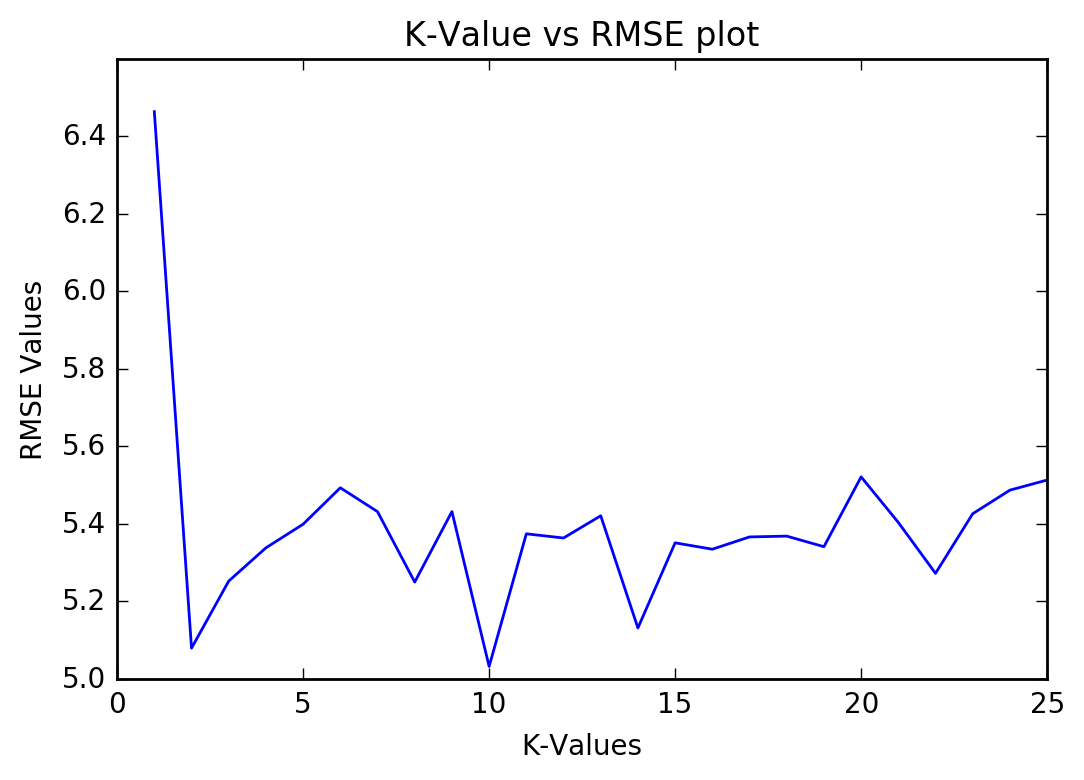

In [34]:
'''
CRIM - 0
ZN - 1
RM - 5
AGE - 6
DIS - 7
TAX - 9
'''
# Create new matrix of features and dependent variable
bdata_new = bdata_full[:,(0,1,5,6,7,9,13)]

# List to store k-values
x=[]
# List to store rmse values
y=[]
# List to store time, which we will use to record runtime
ti =[]

for k_value in range(1,26):
    # Calculating the RMSE and time taken 
    r,t = kfold(bdata_new,2,'knn',k_value)
    # Appending the value of iteration to x list
    x.append(k_value)
    # Appending corresponding RMSE value to y list
    y.append(r)
    ti.append(t)

# Convert our lists to array
x = np.array(x)
y = np.array(y)
ti = np.array(ti)
# Create 2-D array containg the k-values and their corresponding RMSE value
kvsr = np.stack((x,y),axis = -1)
print("Total run time of the algorithm is",(sum(ti)/60),"Minutes")
# Plotting the K-Value vs RMSE
plt.plot(kvsr[:,0],kvsr[:,1])
plt.xlabel("K-Values")
plt.ylabel("RMSE Values")
plt.title("K-Value vs RMSE plot")

From the above plot, we see that the lowest RMSE value is attained at K=10 . Hence, using k=10 is a reasonable choice for our model.

## Forward selection

Thus far the choice of predictor variables has been rather arbitrary. We will now implement a basic forward select algorithm to progressively include features that decrease the cross-validated RMSE of the model. Note that the optimal value of K may be different for each model, so we may want to use cross-validation to choose K each time (but it is also fine if you fix K at the optimal value from 2.7).

To start the forward selection process, we will have to select an optimal parameter to start the forward selection process with. Hence, we run the nearest neighbour for every feature individually using 10 neighbours, since it was the optimal value from 3.7.

In [35]:
temp = {}
for i in range(13):
    r,t = kfold(bdata_full[:,(i,13)],2,'knn',10)
    temp[i] = r

In [219]:
print("The minimum value of rmse is:",temp[min(temp, key=temp.get)])
print("The minimum value occurs on the index:",min(temp, key=temp.get))

The minimum value of rmse is: 5.86460041789
The minimum value occurs on the index: 12


From the above we see that we found the lowest RMSE value for index 12 i.e LSTAT feature. We will start our forward selection process with this variable as the base. On each iteration, we will find RMSE for every feature addition and add the feature whose addition leads to the lowest RMSE value. This will continue until the RMSE no longer decreases.

In [220]:
# Array to store index of features that improve the model in the order they were added
x = []
# Reduced rmse value at every step
r_values = []
# Setting temp value to index 12 i.e the feature we will start with
temp = 12
# Setting based rmse value to the one found on the previous step.
r_init = 5.86460041789
# Forward selection process
for i in range(12):
    x.append(temp)
    r_values.append(r_init)
    r_min = r_init
    for j in range(12):
        # Skip the index if it is already added to the model from previous iterations
        if j in x:
            continue
        x.append(j)
        x.append(13)
        x = tuple(x)
        #print(x) : For testing if the algorithm is working as intended.
        r,t = kfold(bdata_full[:,x],2,'knn',10)
        #print(r) : For testing if the algorithm is working as intended.
        if r < r_init:
            x = list(x)
            del x[-1]
            del x[-1]
            r_init = r
            temp = j
        else:
            x = list(x)
            del x[-1]
            del x[-1]
    # Exit the forward selection process if no more improvement is possible
    if r_min == r_init:
        break


In [255]:
# Create list of feature names in the order they appear in the dataset
f_names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
f_names = np.array(f_names)

In [253]:
print("The final (lowest) RMSE value after forward selection process is:",min(r_values))
print("Indexes of features in the final model are:",x)
print("Features by name:",f_names[(x),])

The final (lowest) RMSE value after forward selection process is: 3.98144627376
Indexes of features in the final model are: [12, 5, 4, 11, 7, 9, 10, 6]
Features by name: ['LSTAT' 'RM' 'NOX' 'B' 'DIS' 'TAX' 'PTRATIO' 'AGE']


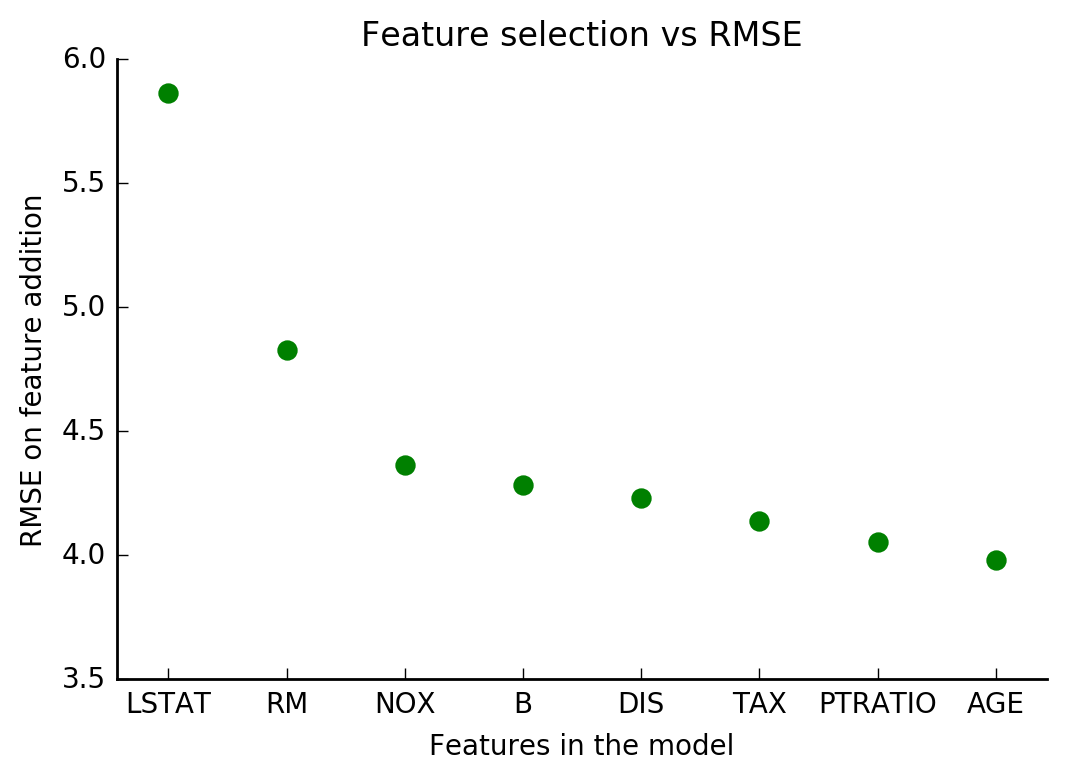

In [254]:
z = np.array([1,2,3,4,5,6,7,8])
y = np.array(r_values)
my_xticks = f_names[(x),]
plt.xticks(z, my_xticks)
plt.scatter(z, y,s = 40, color = 'green')
plt.xlabel('Features in the model')
plt.ylabel('RMSE on feature addition')
plt.title('Feature selection vs RMSE')
ax = plt.axes()
ax.spines['right'].set_color('none') # Remove right axis
ax.spines['top'].set_color('none') # Remove top axis
ax.get_xaxis().tick_bottom() # Remove top ticks
ax.get_yaxis().tick_left() # Remove right ticks

Hence, after forward selection, our final model contains the features LSTAT,RM,NOX,B,DIS,TAX,PTRATIO and AGE.
The root mean squared error for the final model is 3.98.

## Principal Component Analysis

In [4]:
bdata_full = np.insert(bdata.data, bdata.data.shape[1], bdata.target, axis = 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(bdata_full[:,0:13], bdata_full[:,13], test_size = 0.34, random_state = 1)

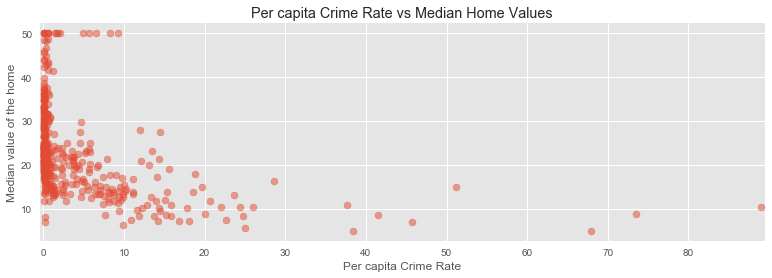

In [14]:
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(13,4))
ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.scatter(bdata_full[:,0],bdata_full[:,13],alpha = 0.5)
plt.xlim([bdata_full[:,0].min()-0.5,bdata_full[:,0].max()+0.5])
plt.xlabel('Per capita Crime Rate')
plt.ylabel('Median value of the home')
plt.title('Per capita Crime Rate vs Median Home Values')

In [15]:
def compute_rmse(predictions, yvalues):
    squared = (np.asarray(predictions) - np.asarray(yvalues)) **2
    root_ms = np.sqrt(squared.sum()/len(predictions))
    return root_ms

In [16]:
from sklearn.linear_model import LinearRegression
# Running Linear Regression
lin_reg = LinearRegression()
# Fitting the model
lin_reg.fit(X_train[:,5:6], y_train)
pred_train = lin_reg.predict(X_train[:,5:6])
pred_test = lin_reg.predict(X_test[:,5:6])

In [17]:
rmse_train = compute_rmse(pred_train,y_train)
rmse_test = compute_rmse(pred_test,y_test)

In [18]:
print('RMSE on training set is:',rmse_train)
print('RMSE on the test set is:',rmse_test)

RMSE on training set is: 6.64462675774
RMSE on the test set is: 6.53144557911


## So many scatterplots!

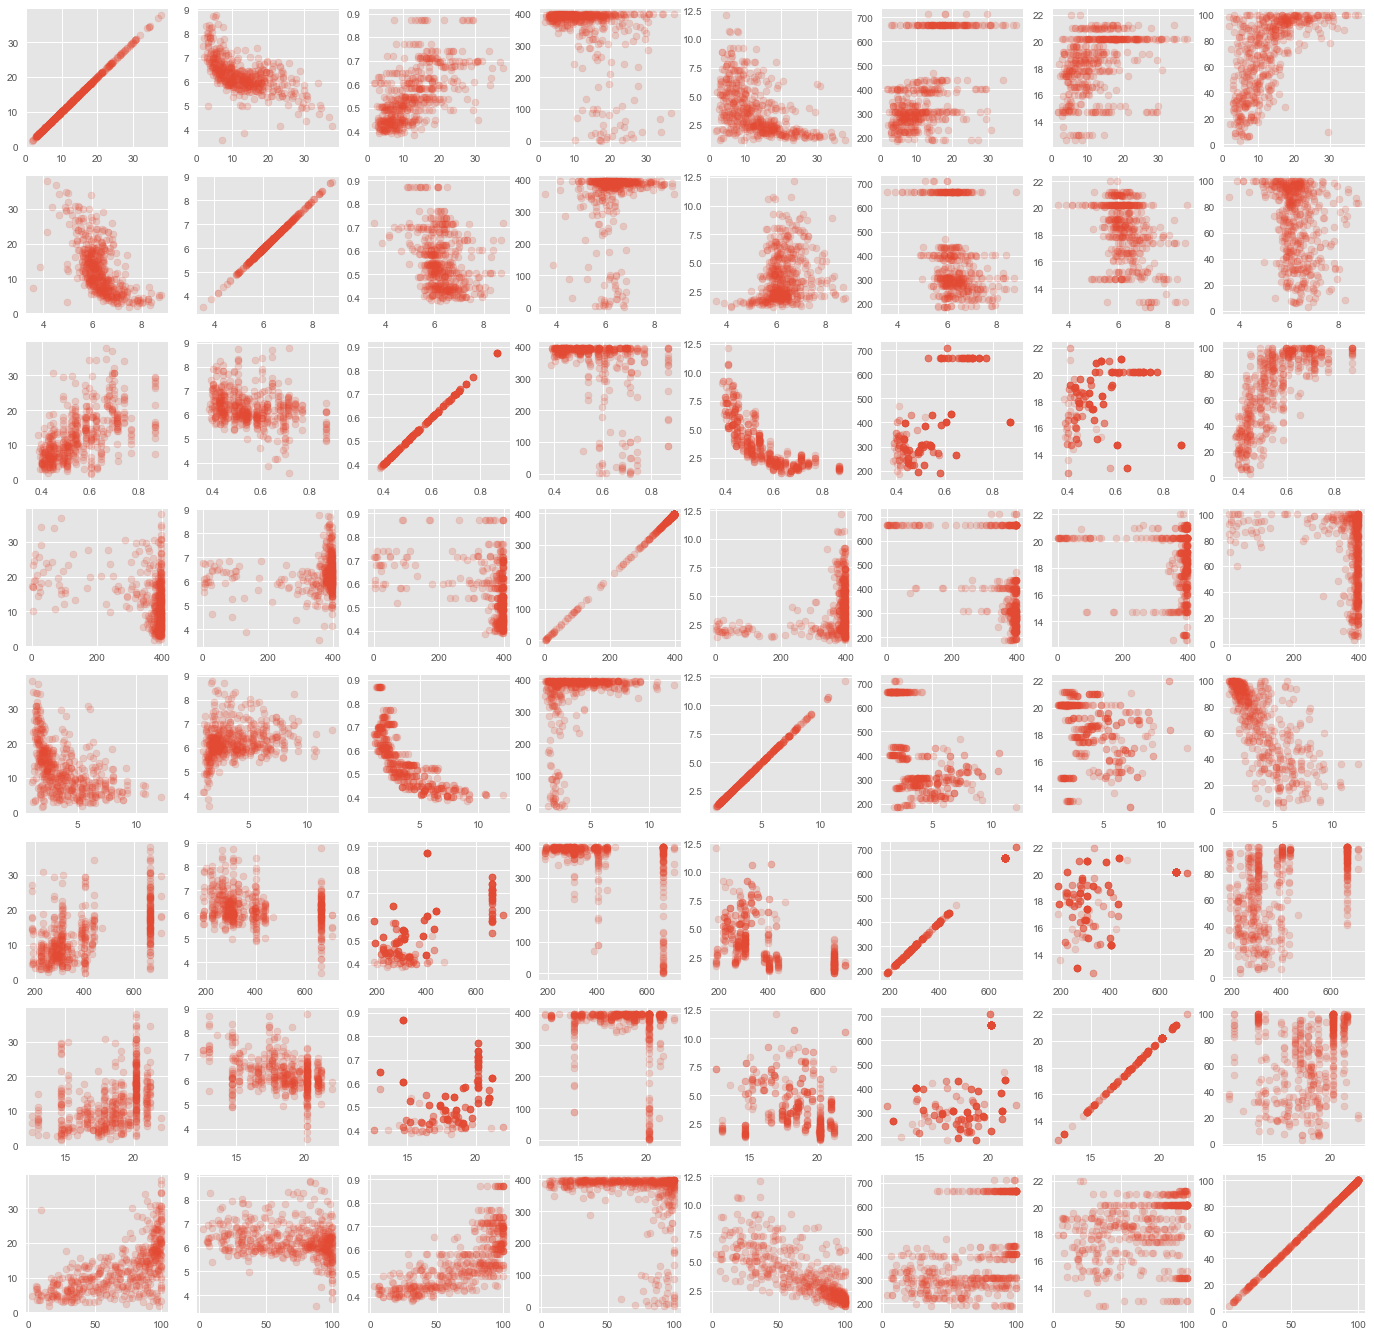

In [19]:
# Using features found from forward select in assignment
bdata_features = bdata_full[:,(12, 5, 4, 11, 7, 9, 10, 6)]
plt.figure(figsize=(24,24))
for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, i * 8 + j + 1)
        plt.scatter(bdata_features[:,i],bdata_features[:,j],alpha = 0.2)

## PCA to the rescue

We will run principal component analysis using PCA from sklearn to find the first 12 principal components of your data. 

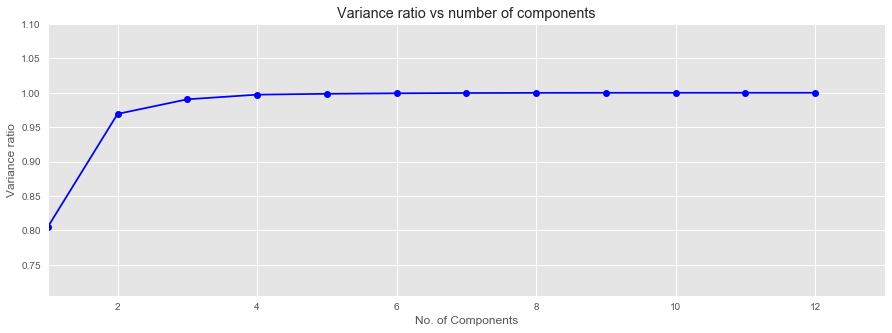

In [21]:
plt.figure(figsize=(15,5))

ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

pca = PCA(n_components=12)
pca.fit(X_train)
result = pca.explained_variance_ratio_

# Initialize variable to store variance ration
sum = 0

Y_values = []
for i in result:
    sum+=i
    Y_values.append(sum)

 
X_values = [1,2,3,4,5,6,7,8,9,10,11,12]

plt.plot(X_values, Y_values,marker='o', color='b')
plt.ylim([Y_values[0]-0.1,1.1])
plt.xlim([1,13])
plt.xlabel("No. of Components")
plt.ylabel("Variance ratio")
plt.title("Variance ratio vs number of components")

## Visualizing the components

In [22]:
pca_data = pca.fit_transform(X_train)

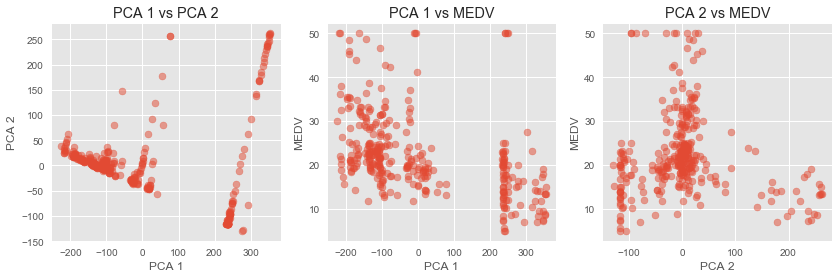

In [24]:
# plt.scatter(pca_data[:,0:1],pca_data[:,1:2])

fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(1,3,1)
ax1 = plt.scatter(pca_data[:,0],pca_data[:,1],alpha = 0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA 1 vs PCA 2')
ax2 = fig.add_subplot(1,3,2)
ax2 = plt.scatter(pca_data[:,0:1],y_train, alpha = 0.5)
plt.xlabel('PCA 1')
plt.ylabel('MEDV')
plt.title('PCA 1 vs MEDV')
ax3 = fig.add_subplot(1,3,3)
ax3 = plt.scatter(pca_data[:,1:2],y_train, alpha = 0.5)
plt.xlabel('PCA 2')
plt.ylabel('MEDV')
plt.title('PCA 2 vs MEDV')

## Regression and PCA

In [25]:
pca_data_train = pca.transform(X_train)
pca_data_test = pca.transform(X_test)
lin_reg_1 = LinearRegression()
# Fitting the model
lin_reg_1.fit(pca_data_train[:,0:1], y_train)
pred_train = lin_reg_1.predict(pca_data_train[:,0:1])
pred_test = lin_reg_1.predict(pca_data_test[:,0:1])

In [26]:
print('RMSE On Training set is:',compute_rmse(pred_train,y_train))
print('RMSE On Test set is:',compute_rmse(pred_test,y_test))

RMSE On Training set is: 8.09926699078
RMSE On Test set is: 7.89801937683


From the above results, we see that the RMSE on the training set has gone up from 6.64 to 8.09 on the training set. While, the RMSE on the test set has gone up from 6.53 to 7.89. There can be multiple reasons for this. While earlier we had used the 'RM' feature to predict the house prices, which is a good predictor, as we saw from forward selection. We are using a single PCA here which can be a combination of more than 1 features, as we have reduced the dimensions from 12 to 13. The slight increase in RMSE may not necessarily a bad thing, as we see even when we reduce the dimensionality of our feature set, our model does not perform significantly worse. As such a we have seen earlier that 1 feature alone explaning about 95% of the variance in data. Using multiple PCAs, we may be able to get a better value for the RMSE.